In [ ]:
# Libraries used
import scipy.io as sio
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import welch

# 1. Preprocessing

Load and inspect the .mat files.

Extract and reshape EEG signals converting it to DataFrames.

Each cell = a 3D array [n_subjects, n_samples, n_channels]

In [68]:
def load_group(file_name, group_label, gender):
    # Load .mat files
    data = sio.loadmat(os.path.join('EEG', file_name + '.mat'))
    # Get only the last column where all the information that we need is
    key = list(data.keys())[-1]
    group_data = data[key]

    rows = []
    # Loop through each cell (tasks)
    for task_idx in range(group_data.shape[1]):
        task_data = group_data[0, task_idx]
        n_subjects, n_samples, n_channels = task_data.shape

        for subj_idx in range(n_subjects):
            # Handle corrupted sample (skip female ADHD subject 7)
            if file_name == "FADHD" and subj_idx == 6:
                continue
            
            # This will make it easier to know later to which signal we are referring
            signal = task_data[subj_idx, :, :]  # [samples x channels]
            rows.append({
                "group": group_label,    # 'Control' or 'ADHD'
                "gender": gender,        # 'Male' or 'Female'
                "task": task_idx + 1,    # 1 to 11
                "subject_id": f"{file_name}_{subj_idx+1}",
                "signal": signal
            })
    return pd.DataFrame(rows)

# Load all four groups
fc_df = load_group("FC", group_label="Control", gender="Female")
mc_df = load_group("MC", group_label="Control", gender="Male")
fadhd_df = load_group("FADHD", group_label="ADHD", gender="Female")
madhd_df = load_group("MADHD", group_label="ADHD", gender="Male")

# Combine
eeg_df = pd.concat([fc_df, mc_df, fadhd_df, madhd_df], ignore_index=True)


In [67]:

eeg_df.head()
# print(eeg_df.shape)

,group,gender,task,subject_id,signal
0,Control,Female,1,FC_1,"[[-71.856, -3.104], [-344.555, -63.584], [-255..."
1,Control,Female,1,FC_2,"[[-6.587, 28.138], [-26.127, 52.008], [-14.1, ..."
2,Control,Female,1,FC_3,"[[-149.667, -144.478], [-303.2, -72.021], [-61..."
3,Control,Female,1,FC_4,"[[9.157, 5.49], [-27.11, 25.285], [-14.297, 11..."
4,Control,Female,1,FC_5,"[[13.423, 59.656], [8.419, -14.864], [-4.453, ..."


## Visualization of data

Visual inspection of signals. In the graph below the first subject is plotted, the first task and the firs channel: Eyes open baseline in channel Cz.

The x-axis represents the time (in samples) → 7680 samples = 30 s of recording.

And the y-axis is the EEG amplitude in microvolts (µV).

So the plot represents the time-domain EEG waveform of one electrode (Cz).

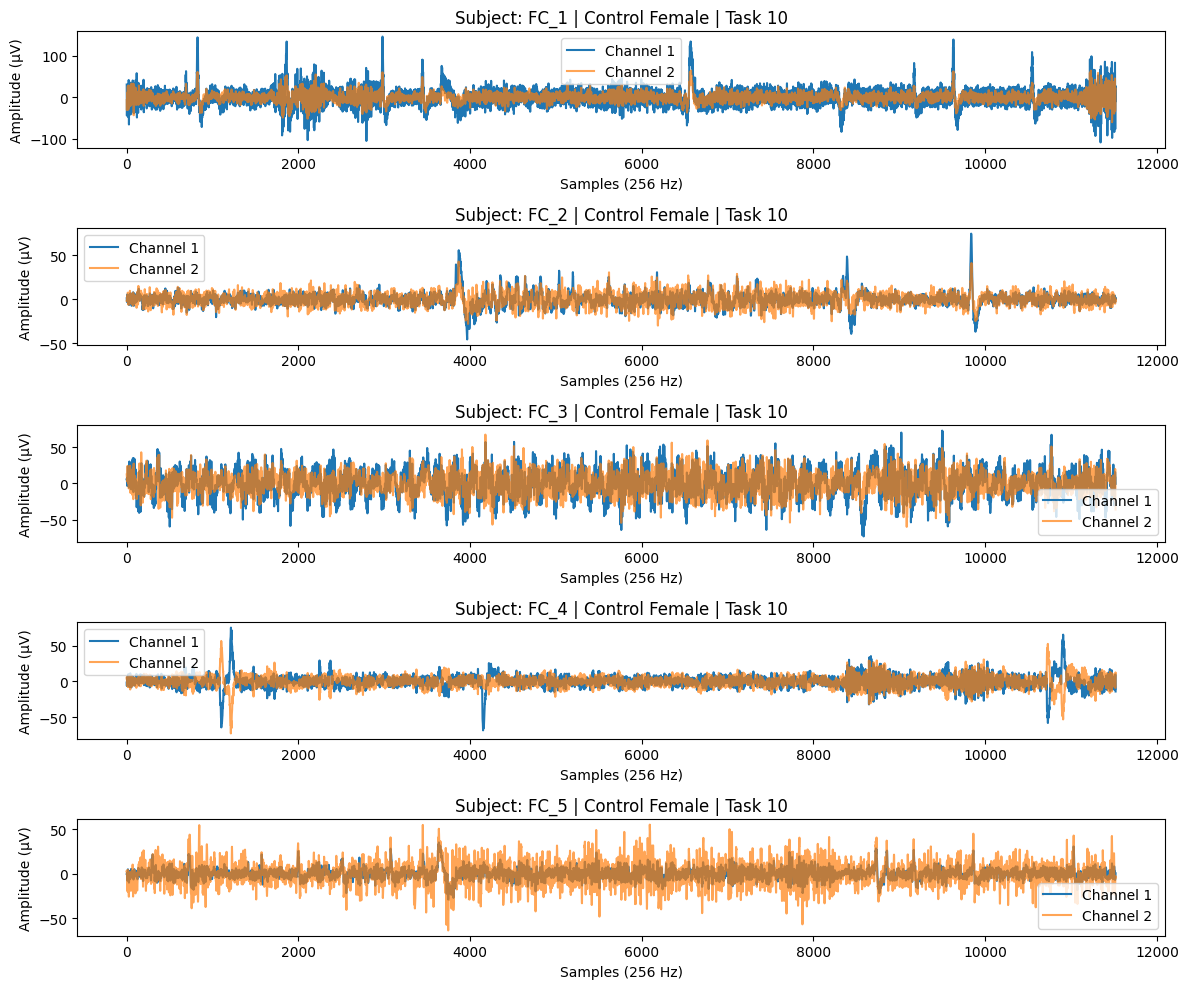

In [135]:
# Visualize the channels of a subject doing a task
def visualize_task(df, group, gender, task=1, n=5):

    subset = df[(df["group"] == group) & (df["gender"] == gender) & (df["task"] == task)].head(n)
    
    if subset.empty:
        print(f"No data found for {group} {gender}, Task {task}")
        return

    plt.figure(figsize=(12, 2 * n))

    for i, (_, row) in enumerate(subset.iterrows(), start=1):
        signal = row["signal"]
        
        # plt.xlim(0, 2000)
        plt.subplot(n, 1, i)
        plt.plot(signal[:, 0], label="Channel 1")
        plt.plot(signal[:, 1], label="Channel 2", alpha=0.7)
        plt.title(f"Subject: {row['subject_id']} | {group} {gender} | Task {task}")
        plt.xlabel("Samples (256 Hz)")
        plt.ylabel("Amplitude (µV)")
        plt.legend()

    plt.tight_layout()
    plt.show()

visualize_task(fc_df, 'Control', 'Female', task=10, n=5)

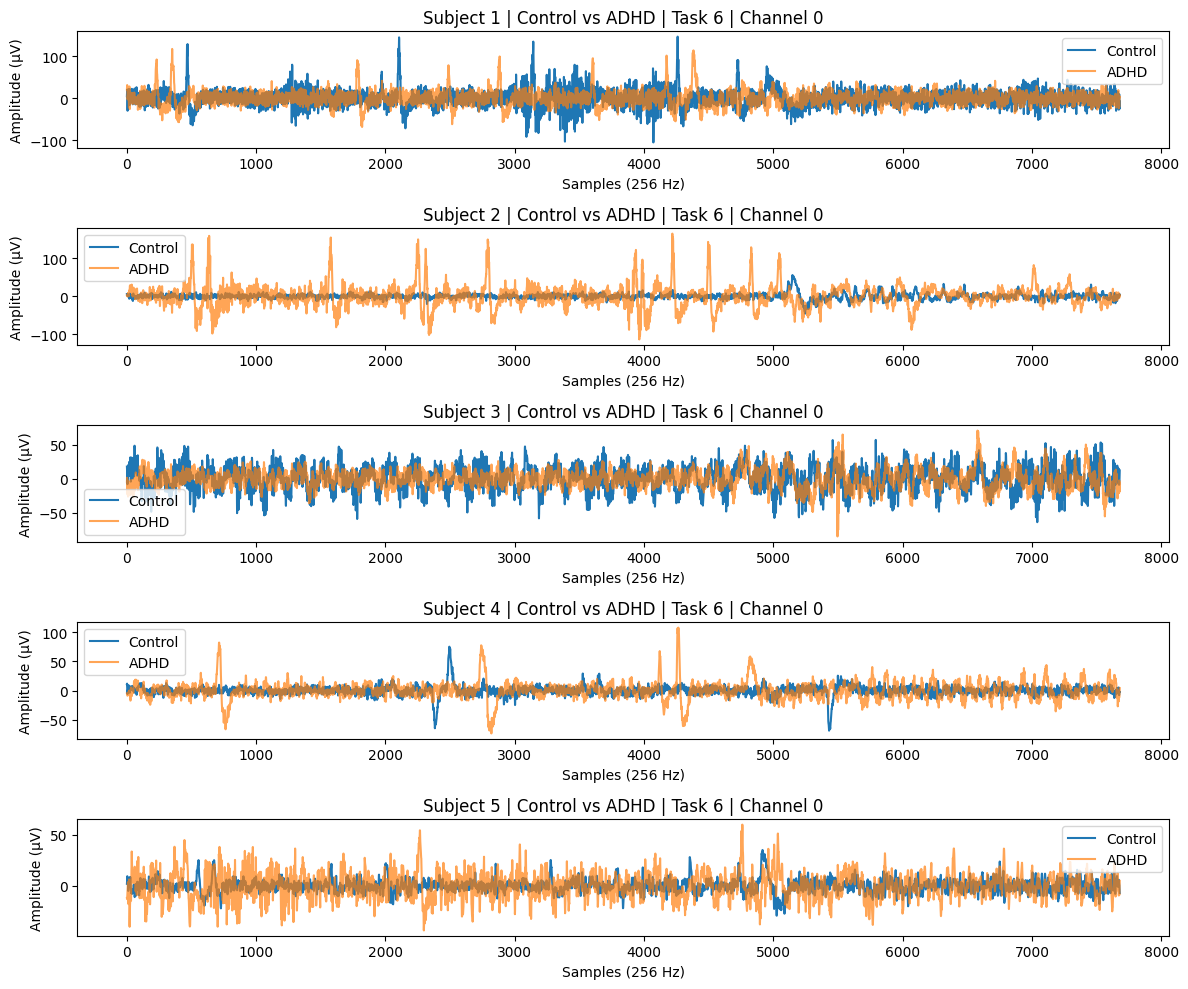

In [134]:
# Visualize the difference between ADHD and non for a task (for just one channel)
def visualize_adhd(control_df, adhd_df, channel=0, task=1, n=5):

    control_set = control_df[(control_df["task"] == task)].head(n)
    adhd_set = adhd_df[(adhd_df["task"] == task)].head(n)

    if control_set.empty or adhd_set.empty:
        print("No data found")
        return
    if channel > 1:
        print("Channel not found")
        return

    plt.figure(figsize=(12, 2 * n))

    for i in range(n):
        control_signal = control_set.iloc[i]["signal"]
        adhd_signal = adhd_set.iloc[i]["signal"]

        # plt.xlim(0, 2000)
        plt.subplot(n, 1, i + 1)
        plt.plot(control_signal[:, channel], label="Control")
        plt.plot(adhd_signal[:, channel], label="ADHD", alpha=0.7)
        plt.title(f"Subject {i+1} | Control vs ADHD | Task {task} | Channel {channel}")
        plt.xlabel("Samples (256 Hz)")
        plt.ylabel("Amplitude (µV)")
        plt.legend()

    plt.tight_layout()
    plt.show()

visualize_adhd(fc_df, fadhd_df, channel=0, task=6, n=5)